In [1]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import odeint
from utils import reshape_dataset_to_torch, train_L63

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# parameters of the training experiment
params = {'grad_mode': 'EGA-static','dim_state': 3, 'dim_output': 3, 'transition_layers': 2, 'dim_hidden_dyn_mdl': 3, 'train_size': 5000,
          'ntrain': 300, 'dt_integration': 0.01, 'pretrained': False, 'Batch_size': 128, 'seq_size': 10,
          'nb_part': 5, 'output_folder': 'output_models/',
          'model_save_file_name': 'L63_EGA-static.pt', 'device': 'cuda'}

In [4]:
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # params of the true L63 system
        self.device = params['device']
        self.sigma = GD.parameters.sigma
        self.rho = GD.parameters.rho
        self.beta = GD.parameters.beta

        # params of the neural network correction
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend([torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
                                 range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])

    def closure(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

    def dyn_net(self, inp, t, closure = True):
        grad = np.zeros((inp.shape[0]))
        grad[0] = self.sigma * (inp[1] - inp[0])
        grad[1] = inp[0] * (self.rho - inp[2]) - inp[1]
        grad[2] = inp[0] * inp[1]  # + self.beta*inp[:,2];
        if closure:
            return grad + self.closure(torch.from_numpy(inp[np.newaxis]).float().to(self.device)).cpu().numpy()[0,:]
        else:
            return grad
    def model_dt(self, inp, dt, t0=0,
                grad_mode='exact'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        with torch.no_grad():
            pred = torch.zeros_like(inp)
            for i in range(inp.shape[0]):
                # blackbox non diff solver
                pred[i,:] = torch.from_numpy(odeint(self.dyn_net, inp[i,:].cpu().numpy(), np.arange(t0, dt + 0.000001, dt))[-1,:]).float().to(inp.device)
        # computational graph of the blackbox solver
        if grad_mode == 'EGA-static':
            output_p = dt * self.closure(inp.detach()) + inp
            output_p.data = pred.data[:, :]
        elif grad_mode == 'EGA-ST':
            output_p = dt * self.closure(inp) + inp
            output_p.data = pred.data[:, :]
        elif grad_mode == 'EGA-J':
            output_p = dt * self.dyn_net(inp, t0+dt) + inp
            output_p.data = pred.data[:, :]                
        return output_p
    def forward(self,dt, n, x0, closure = True, grad_mode = 'EGA-static'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1],dt, grad_mode = grad_mode))
        pred_seq = torch.stack(pred)
        return pred_seq

In [5]:
class GD:
    model = 'Lorenz_63'

    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3

    dt_integration = params['dt_integration']  # integration time
    nb_loop_data = 60.0

In [6]:
# run the data generation
dataset = generate_data(GD)

In [7]:
# reshaping dataset
X_train, Y_train, X_test, Y_test = reshape_dataset_to_torch(dataset, params['seq_size'], params['train_size'])
training_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=params['Batch_size'], shuffle=True,
                                         pin_memory=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=params['Batch_size'], shuffle=False, pin_memory=False),
}

In [8]:
hybrid_L63 = HybridMdl(params).to(params['device'])

In [9]:
optimizer_ft = torch.optim.Adam(hybrid_L63.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)
model_best_valid, model, loss_train, loss_val = train_L63(hybrid_L63, dataloaders, optimizer_ft, exp_lr_scheduler, device=params['device'], num_epochs=params['ntrain'], dt=params['dt_integration'], seq_size=params['seq_size'], grad_mode=params['grad_mode'])
torch.save(model.state_dict(), params['output_folder'] + params['model_save_file_name'])

Epoch 0/299
----------
train: loss: 0.323947
LR 0.1
val: loss: 0.242793
saving best model
Epoch 1/299
----------
train: loss: 0.190653
LR 0.1
val: loss: 0.143204
saving best model
Epoch 2/299
----------
train: loss: 0.115858
LR 0.1
val: loss: 0.090166
saving best model
Epoch 3/299
----------
train: loss: 0.076537
LR 0.1
val: loss: 0.065465
saving best model
Epoch 4/299
----------
train: loss: 0.059699
LR 0.1
val: loss: 0.055499
saving best model
Epoch 5/299
----------
train: loss: 0.052901
LR 0.1
val: loss: 0.052212
saving best model
Epoch 6/299
----------
train: loss: 0.050165
LR 0.1
val: loss: 0.051320
saving best model
Epoch 7/299
----------
train: loss: 0.049467
LR 0.1
val: loss: 0.051184
saving best model
Epoch 8/299
----------
train: loss: 0.049496
LR 0.1
val: loss: 0.051204
Epoch 9/299
----------
train: loss: 0.049356
LR 0.1
val: loss: 0.051198
Epoch 10/299
----------
train: loss: 0.049451
LR 0.1
val: loss: 0.051184
Epoch 11/299
----------
train: loss: 0.050812
LR 0.1
val: loss:

In [10]:
initial_condition_test = next(iter(dataloaders['val']))[0][0,:]
simulation_hybrid = odeint(model_best_valid.dyn_net,initial_condition_test,np.arange(0,40+0.000001,GD.dt_integration),args=(False,))
simulation_init_sys  = odeint(model_best_valid.dyn_net,initial_condition_test,np.arange(0,40+0.000001,GD.dt_integration),args=(False,))

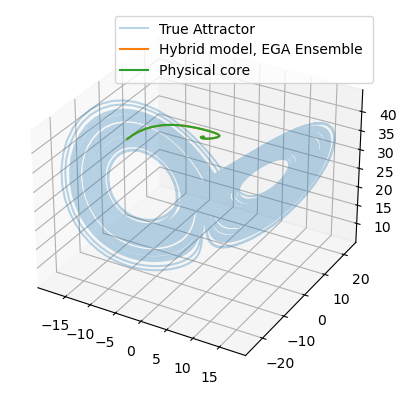

In [11]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the line in 3D
ax.plot(dataset[:,0], dataset[:,1], dataset[:,2], label='True Attractor', alpha = 0.3)
ax.plot(simulation_hybrid[:,0], simulation_hybrid[:,1], simulation_hybrid[:,2], label='Hybrid model, EGA Ensemble ')
ax.plot(simulation_init_sys[:,0], simulation_init_sys[:,1], simulation_init_sys[:,2], label='Physical core')
plt.legend()